# 07-04 - Graph Reconstruction

*June 7 2023*  

Link prediction refers to the task to predict which pairs of unconnected nodes in a training network are likely to be connected by a link in the test network. We can also take a different perspective: Rather than splitting the network into a training-test set of edges, we can compute the similarities between all nodes in the full (observed) network and then try to reconstruct all links in the network based on the pair-wise similarities between nodes. We consider a variable number of $k$ most similar node pairs and predict that a link exists between them. For each value of $k$ we calculate the **precision** of our prediction, i.e. for which fraction of the $k$ predicted links a link exists in the network (which is the probability that a positive class prediction is correct). We call this task *graph reconstruction* and we can compute it to evaluate similarity scores in networks.

In [1]:
import pathpy as pp
import numpy as np
import pandas as pd 
from sklearn import metrics
from scipy.sparse import linalg as spl
import scipy as sp

from matplotlib import pyplot as plt
from itertools import combinations

import seaborn as sns

plt.style.use('default')
sns.set_style("whitegrid")

We use the same empirical network as before:

In [2]:
n = pp.io.graphtool.read_netzschleuder_network('student_cooperation')
print(n)

[06-15 18:34:40: WARNING] 49 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


Uid:			0x7f2b4e800b20
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	185
Number of edges:	311

Network attributes
------------------
name:	student_cooperation
description:	Network of cooperation among students in the "Computer and Network Security" course at Ben-Gurion University, in 2012. Nodes are students, and edges denote cooperation between students while doing their homework. The graph contains three types of links: Time, Computer, Partners.[^icon]
[^icon]: Description obtained from the [ICON](https://icon.colorado.edu) project.
citation:	[['M. Fire et al., "Predicting student exam\'s scores by analyzing social network data." International Conference on Active Media Technology, 584-595 (AMT 2012)', 'https://doi.org/10.1007/978-3-642-35236-2_59']]
url:	https://data4goodlab.github.io/MichaelFire/#section3
tags:	['Social', 'Offline', 'Multigraph', 'Unweighted']
title:	Student cooperation (2012)
bibtex:	["@incollection{fire_predicting_2012,\n  doi          = {1

We generate a `pandas` data frame that contains *all* node pairs and assign the ground truth to each pair, i.e. whether an edge exists or not. We further implement a function that assigns a similarity score to each rows in the data frame.

In [3]:
node_pairs = pd.DataFrame([ (v.uid, w.uid, (v.uid, w.uid) in n.edges) for v,w in combinations(n.nodes, 2) ], columns=['v', 'w', 'link'])

def assign_sim(network, node_pairs, similarity_score, **kwargs):
    sim = []
    for index, row in node_pairs.iterrows():
        sim.append(similarity_score(network, row['v'], row['w'], **kwargs))
    node_pairs['sim'] = sim

We start with a trivial similarity score, that is identical to the "ground truth" that we want to predict. That is, we assign a similarity of 1 whenever a link exists, and a similarity 0 whenever no link exists.

In [4]:
def node_sim(network, v, w, **kwargs):
    if (v,w) in network.edges:
        return 1
    else:
        return 0

We can assign those similarity scores to all node pairs and rank the node pairs based on their similarity:

In [5]:
assign_sim(n, node_pairs, node_sim)
node_pairs = node_pairs.sort_values('sim', ascending=False)
print(node_pairs)

         v    w   link  sim
0       77   53   True    1
16503  147   63   True    1
11134  112  113   True    1
15251   43   45   True    1
1795     2    5   True    1
...    ...  ...    ...  ...
5712    49  104  False    0
5713    49   11  False    0
5714    49   12  False    0
5715    49  127  False    0
17019   76  182  False    0

[17020 rows x 4 columns]


Let us now predict a link for the k node pairs with highest similarity and calculate the precision score of this prediction. We plot the evolution of the precision as we increase the number of top $k$ ranked node pairs for which we predict a link. We highlight the actual number of edges $m$ in the network by a red vertical line on the x-axis of the plot.

In [6]:
def top_k_prediction(node_pairs):
    prec = []
    for k in range(1, 2*n.number_of_edges()):
        prec.append(len(node_pairs[:k].query('link==True'))/k)
    plt.plot(range(1, 2*n.number_of_edges()), prec)
    plt.axvline(x=n.number_of_edges(), c='r')
    plt.xlabel('Number of predicted links $k$')
    plt.ylabel('Precision')
    plt.ylim(0,1.05)
    plt.tight_layout()

If we use the ground truth as a predictor we expect the precision to be one for all numbers of predicted links k, up to the point where $k>m$, i.e. where $k$ exceeds the actual number of edges in the network.

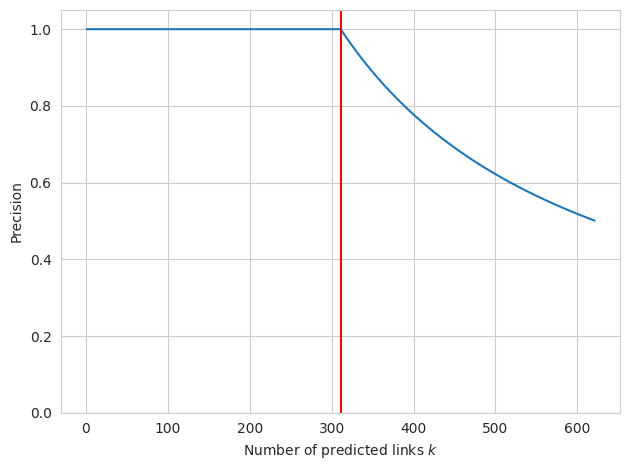

In [7]:
top_k_prediction(node_pairs)

Let us contrast this to a random score, which should have no predictive power at all. Here we should have a close to zero precision for all values of k.

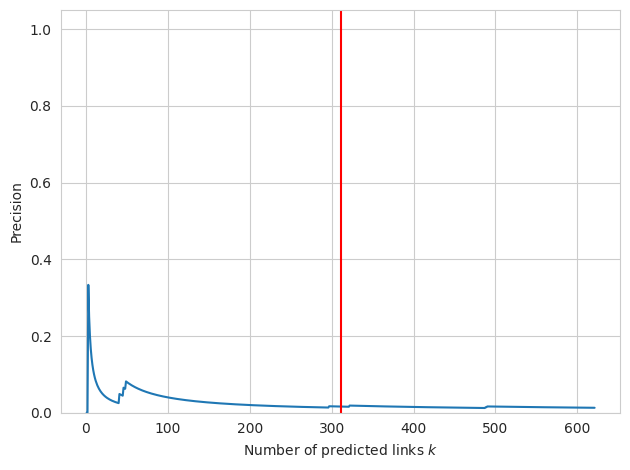

In [8]:
def node_sim(network, v, w, **kwargs):
    return np.random.ranf()

assign_sim(n, node_pairs, node_sim)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)

Let us now contrast this with the plots for some of the similarity scores that we considered before. We find that some of those scores perform very well for very small numbers of $k$, i.e. they have almost perfect precision if we are interested in a small number of $k$ predicted links. This makes them very useful for recommender systems, where we are often interested in a small number of recommendations out of a very large number of possibilities.

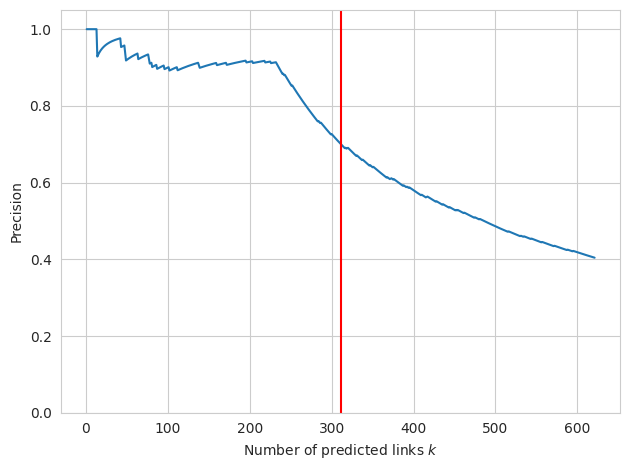

In [9]:
def common_neighbors(n, v, w, **kwargs):
    N_v = n.successors[v]
    N_w = n.successors[w]
    return len(N_v.intersection(N_w))

assign_sim(n, node_pairs, common_neighbors)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)

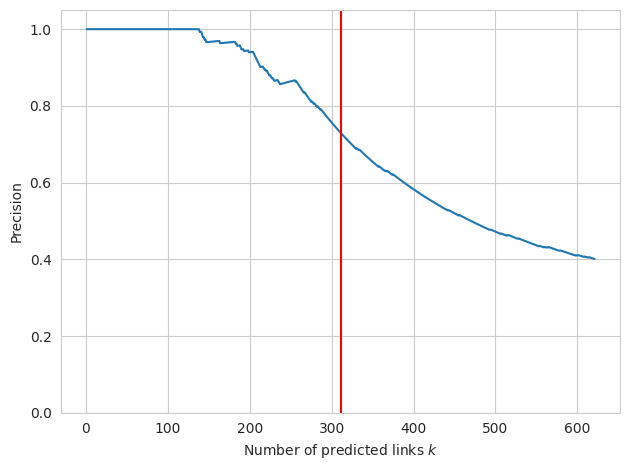

In [10]:
def jaccard_similarity(n, v, w):
    N_v = n.successors[v]
    N_w = n.successors[w]
    intersection = N_v.intersection(N_w)
    if len(N_v) == 0 and len(N_w) == 0:
        return 1
    else:
        return len(intersection)/(len(N_v) + len(N_w) - len(intersection))

assign_sim(n, node_pairs, jaccard_similarity)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)

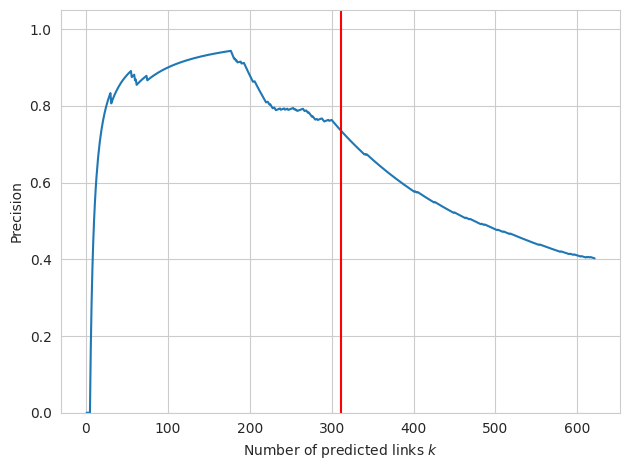

In [11]:
def overlap_coefficient(n, v, w):
    N_v = n.successors[v]
    N_w = n.successors[w]
    if len(N_v) == 0 or len(N_w) == 0:
        return 0
    else:
        return len(N_v.intersection(N_w))/min(len(N_v), len(N_w))

assign_sim(n, node_pairs, overlap_coefficient)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)

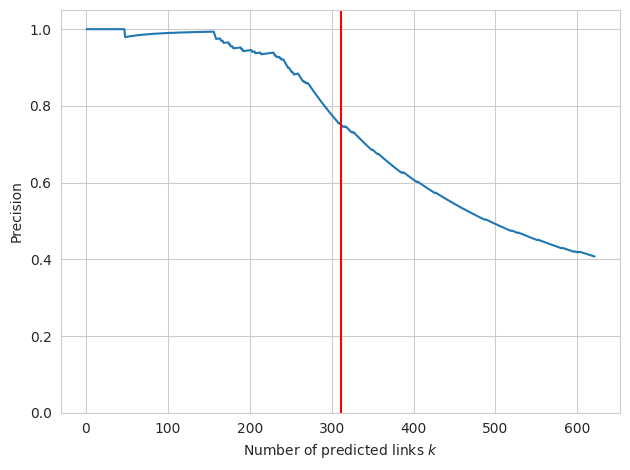

In [12]:
def adamic_adar_index(n, v, w):
    A = 0
    N_v = n.successors[v]
    N_w = n.successors[w]
    for u in N_v.intersection(N_w):
        A += 1 / np.log(len(n.successors[u.uid]))
    return A

assign_sim(n, node_pairs, adamic_adar_index)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)

/home/user/PycharmProjects/ML_for_Complex_Networks/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/user/PycharmProjects/ML_for_Complex_Networks/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


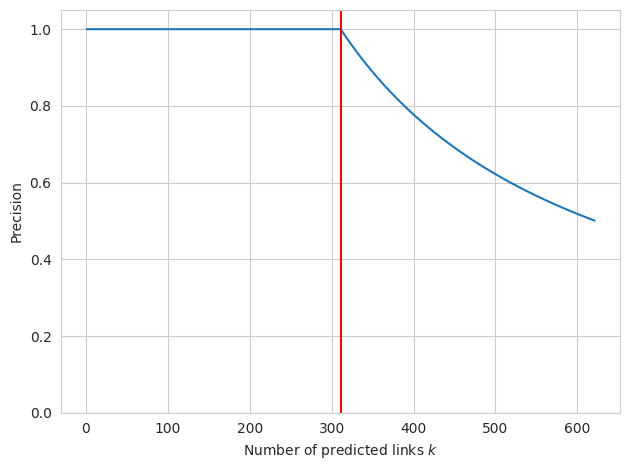

In [13]:
A = pp.algorithms.adjacency_matrix(n)
I = sp.sparse.identity(n.number_of_nodes())
S = sp.sparse.linalg.inv(I - 0.02 * A) - I

def katz_index(network: pp.Network, v, w, **kwargs):    
    return S[network.nodes.index[v], network.nodes.index[w]]

assign_sim(n, node_pairs, katz_index)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)

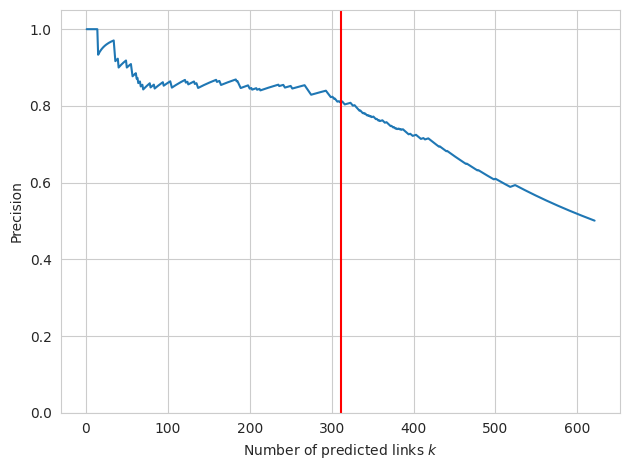

In [14]:
A = pp.algorithms.adjacency_matrix(n)
I = sp.sparse.identity(n.number_of_nodes())
S = sp.sparse.linalg.inv(I - 0.2 * A) - I

def katz_index(network: pp.Network, v, w, **kwargs):    
    return S[network.nodes.index[v], network.nodes.index[w]]

assign_sim(n, node_pairs, katz_index)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)

/home/user/PycharmProjects/ML_for_Complex_Networks/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


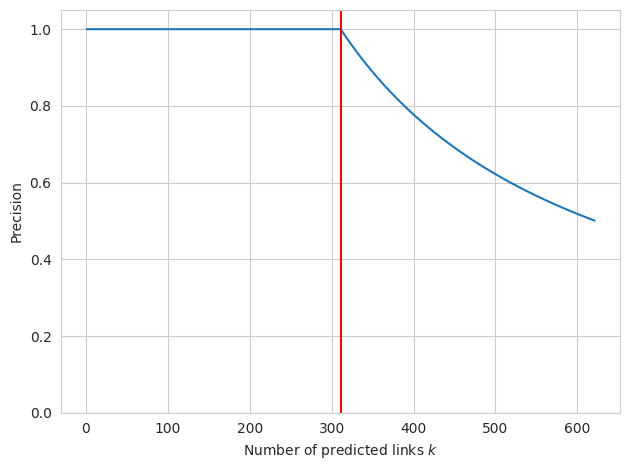

In [15]:
A = pp.algorithms.adjacency_matrix(n)
ev = sp.sparse.linalg.eigs(A, which="LM", k=2, return_eigenvectors=False)
m = n.number_of_edges()
eigenvalues_sorted = np.sort(np.absolute(ev))
lambda_1 = eigenvalues_sorted[0]
D = sp.sparse.diags(pp.statistics.degree_sequence(n))
I = sp.sparse.identity(n.number_of_nodes())
S = 2*m*lambda_1*sp.sparse.linalg.inv(D) * sp.sparse.linalg.inv(I - 0.02*A/lambda_1)*sp.sparse.linalg.inv(D)

def LHN_index(network: pp.Network, v, w, **kwargs) -> float:    
    return S[network.nodes.index[v], network.nodes.index[w]]    

assign_sim(n, node_pairs, katz_index)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)

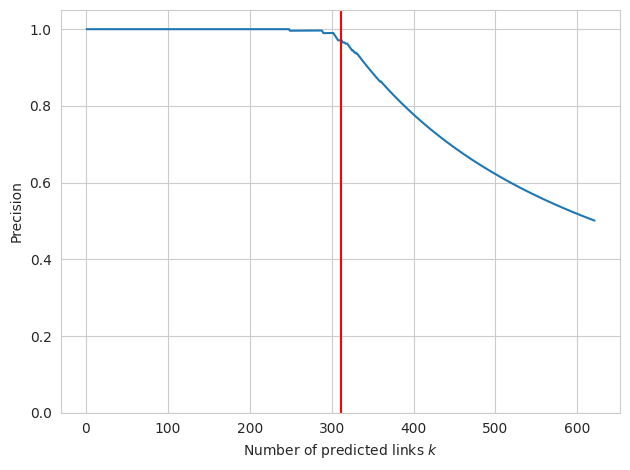

In [16]:
A = pp.algorithms.adjacency_matrix(n)
ev = sp.sparse.linalg.eigs(A, which="LM", k=2, return_eigenvectors=False)
m = n.number_of_edges()
eigenvalues_sorted = np.sort(np.absolute(ev))
lambda_1 = eigenvalues_sorted[0]
D = sp.sparse.diags(pp.statistics.degree_sequence(n))
I = sp.sparse.identity(n.number_of_nodes())
S = 2*m*lambda_1*sp.sparse.linalg.inv(D) * sp.sparse.linalg.inv(I - 0.6*A/lambda_1)*sp.sparse.linalg.inv(D)

def LHN_index(network: pp.Network, v, w, **kwargs) -> float:    
    return S[network.nodes.index[v], network.nodes.index[w]]    

assign_sim(n, node_pairs, katz_index)
node_pairs = node_pairs.sort_values('sim', ascending=False)
top_k_prediction(node_pairs)